# Training the model
**Table of Contents**
1. [Setup](#1-setup)
2. [Dataset Preparation](#2-dataset-preparation)
3. [Training Loop](#3-training-loop)


## 1. Setup

In [1]:
# Automatic reloading
%load_ext autoreload
%autoreload 2

In [2]:
####################
# Required Modules #
####################

# Generic/Built-in
import random
import sys 
import os

# Libs
import torch
import numpy as np
from torch.utils.data import DataLoader

In [3]:
# Add the project root directory to the system path to enable imports from the '/src' folder.

# Get the project directory 
current_dir = os.path.abspath('') # Current '\notebooks' directory
project_dir = os.path.abspath(os.path.join(current_dir, '..')) # Move up one level to project root directory

# Add the project directory to sys.path
sys.path.append(project_dir)

# Move up to project directory
os.chdir(project_dir)
os.getcwd()

# Import custom modules
from src.data_preparation import *
from src.models import *
from src.train_eval import *

c:\Users\Ryan Lee\.conda\envs\term6\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Seeding
SEED = 42

# To be safe, seed all modules for full reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using CUDA
np.random.seed(SEED)
random.seed(SEED)

## 2. Dataset Preparation

In [5]:
train_dataset, val_dataset, test_dataset = prepare_datasets(
    sequence_size=250,
    stride=25,
    num_train=14,
    num_val=2,
    num_test=2,
    random_state=SEED,
    load_if_exists=True
)

✅ HARDataset objects (train/val/test) loaded from saved_components
✅ Created train, validation, and test datasets.


In [6]:
print(f"Train Set: {len(train_dataset)} samples")
print(f"Validation Set: {len(val_dataset)} samples")
print(f"Test Set: {len(test_dataset)} samples")
print(f"Total: {len(train_dataset) + len(val_dataset) + len(train_dataset)} samples")


Train Set: 67781 samples
Validation Set: 10298 samples
Test Set: 9940 samples
Total: 145860 samples


## 3. Training Loop

In [ ]:
# Hyperparameters
batch_size = 256
learning_rate = 0.001
num_epochs = 100
weight_decay = 1e-5 # L2 Regularization coefficient

In [8]:
# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

Load the model in the cell below. There are 4 model architectures to choose from: `HarLSTM`, `HarGRU`, `HarTransformer`, and `HarTransformerExperimental`. The default parameter values should suffice.

In [9]:
# Load model
model = HarTransformerExperimental()

In [10]:
# Training optimizer
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = learning_rate,
    weight_decay=weight_decay
)

In [11]:
# Optional: Continue training by loading trained parameters
trained_params_path = "models/HarTransformerExperimental_2025-04-15_16-28-09/HarTransformerExperimental_best_F1.pth" # Specify path to .pth file here
# model.load_state_dict(torch.load(trained_params_path))

In [12]:
training_loss_history, validation_loss_history, accuracy_history, f1_history, precision_history, recall_history, normalizer = train_HAR70_model(
    model, 
    optimizer, 
    train_dataloader, 
    validation_dataloader, 
    num_epochs = num_epochs
)

Beginning training session...
Model moved to cuda
(1) Creating subdirectory (models\HarTransformerExperimental_2025-04-16_17-02-55) for saving model params...
(2) Computing normalization statistics from the training dataset...
(3) Beginning training loop (100 epochs)...
Epoch [1/100] | Time: 29.73s
(Training) Loss: 0.3117
(Validation) Loss: 0.6806, Accuracy: 0.5122, F1: 0.4513, Precision: 0.5456, Recall: 0.5122
✅ Model saved: models\HarTransformerExperimental_2025-04-16_17-02-55\Best_F1.pth
Epoch [2/100] | Time: 25.49s
(Training) Loss: 0.1618
(Validation) Loss: 1.1997, Accuracy: 0.5005, F1: 0.4332, Precision: 0.5287, Recall: 0.5005
Epoch [3/100] | Time: 26.07s
(Training) Loss: 0.1409
(Validation) Loss: 0.9426, Accuracy: 0.5375, F1: 0.4853, Precision: 0.6651, Recall: 0.5375
✅ Model saved: models\HarTransformerExperimental_2025-04-16_17-02-55\Best_F1.pth
Epoch [4/100] | Time: 26.63s
(Training) Loss: 0.1280
(Validation) Loss: 1.1966, Accuracy: 0.5233, F1: 0.4670, Precision: 0.5909, Recall

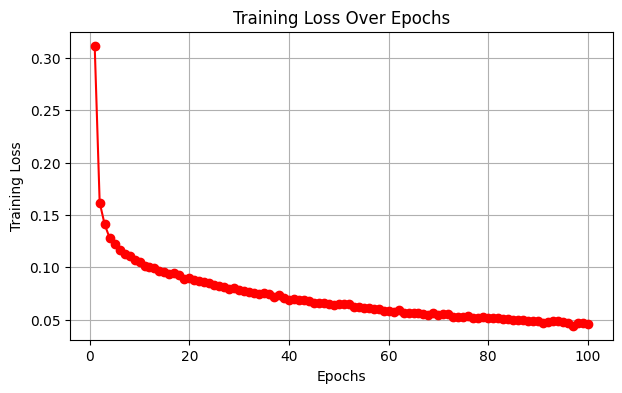

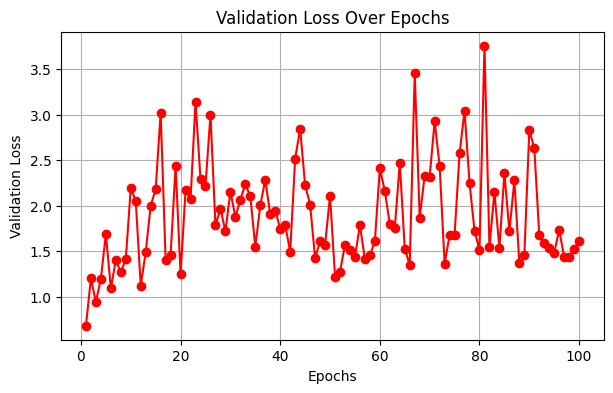

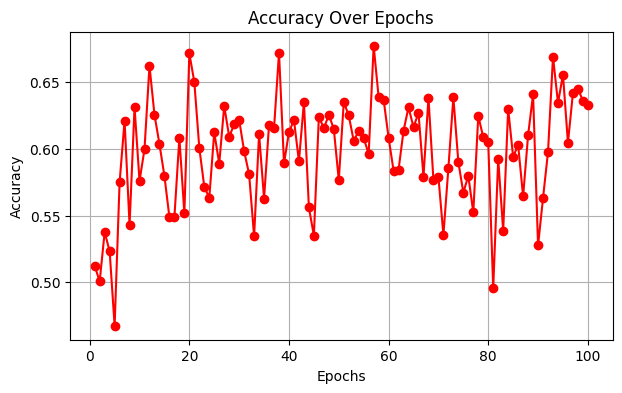

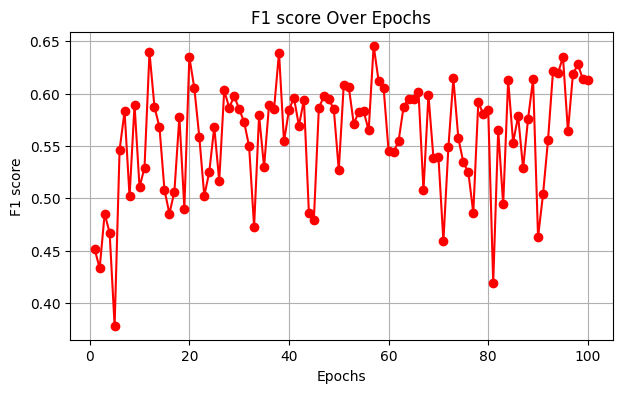

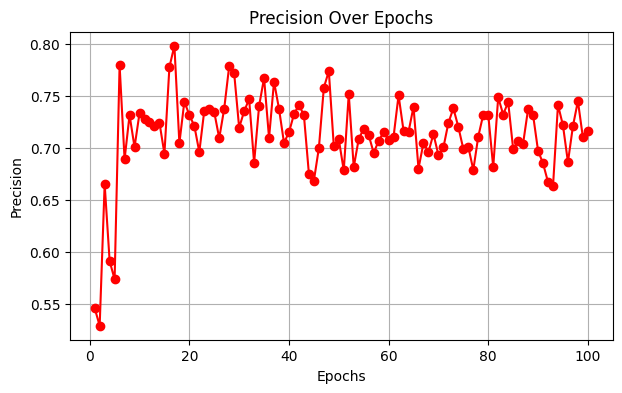

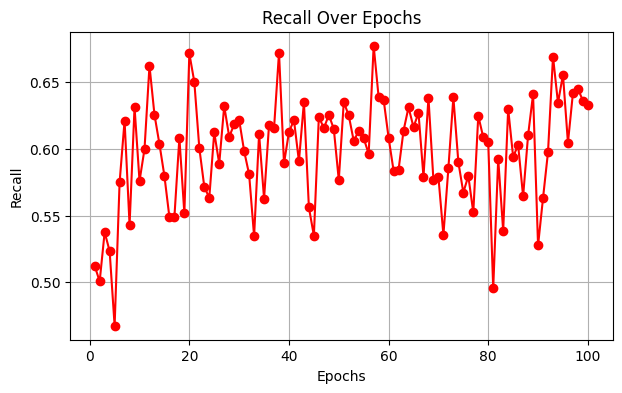

✅ Plots saved to: results\HarTransformerExperimental_2025-04-16_17-48-34
✅ Metric histories saved to: results\HarTransformerExperimental_2025-04-16_17-48-34\metric_histories.pth


In [13]:
save_training_plots_and_metric_history(training_loss_history, validation_loss_history, accuracy_history, f1_history, precision_history, recall_history, type(model).__name__)

In [14]:
# Test metrics
loss, accuracy, f1, precision, recall, conf_matrix = evaluate_HAR70_model(model, test_dataloader, normalizer)
print(f"(Test) Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

(Test) Loss: 0.2859, Accuracy: 0.6051, F1: 0.6252, Precision: 0.7182, Recall: 0.6051
